In [1]:
import numpy as np
import plotly.graph_objects as go
from collections.abc import Mapping

In [2]:
def update(d, u):
    """
    Update the dictionary d from the values of u, recursively with nesteded
    values if needed.
    """
    for k, v in u.items():
        if isinstance(v, Mapping):
            d[k] = update(d.get(k, {}), v)
        else:
            d[k] = v
    return d

# Part 1: Fast computation of $L_\infty$ boundaries

The first task is to implement a fast (i.e., linear, NumPy-enhanced) $L_\infty$ boundary calculator. For an integer radius $r > 0$, there are $8r$ pixels on the boundary of the $L_\infty$ ball of radius $r$. The below code implements a function that computes the boundary.

In [3]:
def boundary(dist):
    """
    Returns a generator of the L_infinity sphere of radius `dist`

    The sphere is the *boundary* of the ball.

    Params
    ------
    dist: int
        radius (discrete)

    Returns
    -------
    pixels: generator
        all pixels with L_infinity distance equalling `dist`

    """
    sphere = []  # L_infinity sphere

    directions = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
    next_directions = np.roll(directions, 1, axis=0)

    for direction, next_direction in zip(directions, next_directions):
        # unit vector for the parallel axis of the current direction
        parallel = (direction != 0).astype(int)
        
        # unit vector for the orthogonal axis of the current direction
        orthogonal = (direction == 0).astype(int)
        
        # forward or backward in the parallel axis
        sign = int(direction[parallel == 1])

        # compute one side of the boundary
        sequence = np.arange(-dist+1, dist)
        tiles = sign * dist * parallel + sequence.reshape((-1, 1)) * orthogonal
        
        # compute the corner separately... it's just easier this way
        corner = dist * (direction + next_direction)

        sphere += list(tiles) + [corner]

    return np.array(sphere)

# Part 2: Compute the "visibility pixel" between the origin and target

Next, compute the representation of the target pixel in the visibility radius of the origin. If the target pixel is within the radius, the target itself is the correct pixel. Otherwise, we compute the L2-distance minimizing path from origin to target, and find its intersection with the boundary of the neighborhood. The closest boundary pixel to this intersection is the "visibility pixel".

In [57]:
def get_visibility_pixel(origin, target, radius):
    """
    Given an origin pixel, target pixel, and neighborhood radius, compute the
    pixel that represents the "visual perception" of the target in the
    neighborhood. 
    
    Either the target pixel is *in* the neighborhood, in which case, the target
    is the perception pixel, or the target pixel is outside the neighborhood,
    in which case we have to find the boundary pixel in the path between the
    orign and target.
    """
    diff = target - origin
    linf_dist = np.abs(diff).max()
    
    if linf_dist <= radius:
        return target
    
    else:
        pixels = boundary(radius) + origin
        
        # "true" location of the intersection of the path and the boundary
        intersection = origin + (radius / linf_dist) * diff
        
        # distances between the true intersection and the boundary pixels
        distances = np.linalg.norm(pixels - intersection, axis=1, ord=2)
        
        index = np.argmin(distances)
        
        return pixels[index]

In [60]:
def draw_pixel(fig, pixel, **kwargs):
    fig.add_shape(
        type='rect',
        x0=pixel[0]-0.5, y0=pixel[1]-0.5,
        x1=pixel[0]+0.5, y1=pixel[1]+0.5,
        **kwargs
    )
    
def draw_neighborhood(fig, origin, radius, **kwargs):
    fig.add_shape(
        type='rect',
        x0=origin[0] - radius - 0.5, y0=origin[1] - radius - 0.5,
        x1=origin[0] + radius + 0.5, y1=origin[1] + radius + 0.5,
        **kwargs
    )
    
def draw_segment(fig, origin, target, **kwargs):
    default_kwargs = {
        'line': {
            'width': 3
        }
    }
    kwargs = update(default_kwargs, kwargs)
    
    fig.add_shape(
        type='line',
        x0=origin[0], y0=origin[1],
        x1=target[0], y1=target[1],
        **kwargs
    )

def plot_intersection(origin, target, radius):
    box = max(np.abs(target).max(), (origin + radius).max()) + 1

    intersection = get_visibility_pixel(origin, target, radius)

    fig = go.Figure()

    draw_neighborhood(fig, origin, radius, fillcolor='#aaaaff')
    draw_segment(fig, origin, target, line=dict(color='#ffffff'))
    draw_pixel(fig, origin, line=dict(color='#0000ff'), fillcolor='#4444ff')
    draw_pixel(fig, target, line=dict(color='#ff0000'), fillcolor='#ff4444')
    draw_pixel(fig, intersection, line=dict(color='#00ff00'), fillcolor='#44ff44')
    
    fig.update_layout(
        template='plotly_dark',
        yaxis=dict(
            scaleanchor='x',
            scaleratio=1,
            range=(-box, box)
        ),
        height=600
    )
    
    return fig

def plot_random_intersections(origin, radius, n_targets, rand_rad=20):
    box = radius + 1

    fig = go.Figure()

    draw_neighborhood(fig, origin, radius, fillcolor='#aaaaff')
    draw_pixel(fig, origin, line=dict(color='#0000ff'), fillcolor='#4444ff')
    
    for _ in range(n_targets):
        target = np.random.randint(-rand_rad, rand_rad+1, size=(2,))
        box = max(box, np.abs(target).max() + 1)
        intersection = get_visibility_pixel(origin, target, radius)
        
        draw_segment(fig, origin, target, line=dict(color='#ffffff'))
        draw_pixel(fig, target, line=dict(color='#ff0000'), fillcolor='#ff4444')
        draw_pixel(fig, intersection, line=dict(color='#00ff00'), fillcolor='#44ff44')
    
    fig.update_layout(
        template='plotly_dark',
        yaxis=dict(
            scaleanchor='x',
            scaleratio=1,
            range=(origin[1]-box, origin[1]+box)
        ),
        xaxis=dict(
            range=(origin[0]-box, origin[1]+box)
        ),
        height=600
    )
    
    return fig

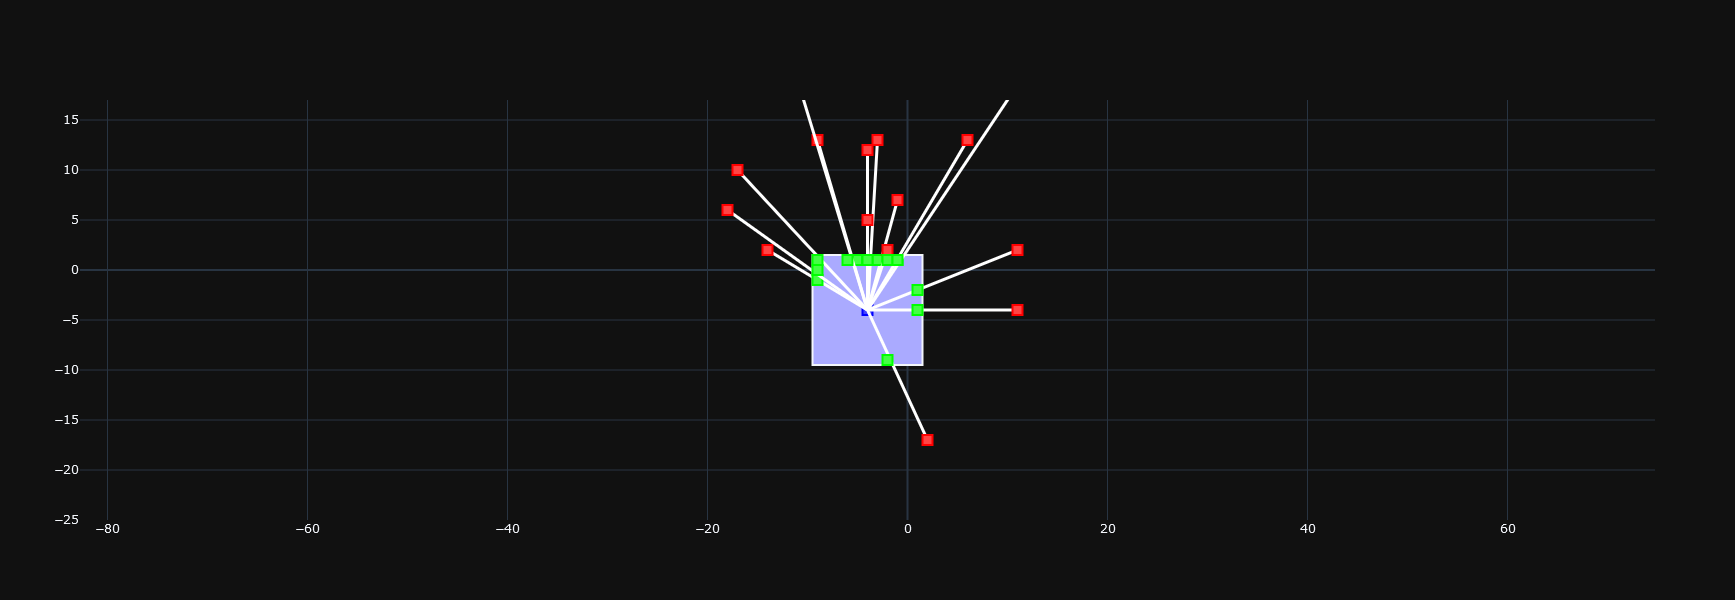

In [66]:
origin = np.random.randint(-5, 5, size=(2,))
plot_random_intersections(origin, 5, 15, rand_rad=20)